In [8]:
from ptp.models.gan_3d.gan3d import Generator
from ptp.models.gan_3d.discriminator import Discriminator
from ptp.models.gan_3d.gan3d import GAN3D
from ptp.models.utils import num_trainable_params
from ptp.evaluation.visualization import visualize_slices, visualize_volumes, plot_slice
from ptp.models.losses import tce_loss
from pathlib import Path
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import nibabel as nib  
import numpy as np
import wandb

from monai.data import MetaTensor
import pytorch_lightning as pl
import torch
from torch import nn
import os

In [9]:
DATA_DIR = Path('/teamspace/uploads')
TARGET_DATA_DIR = DATA_DIR
INPUT_DIR = Path('/teamspace/studios/this_studio')
MODELS_DIR = INPUT_DIR / 'models'
TRAINING_DIR = INPUT_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [10]:
model_name = 'TEST-GAN'
checkpoint_dir = TRAINING_DIR / model_name

In [11]:
percentile = 10
n_critic = 5  # for training more k steps about Discriminator

In [12]:
gan = GAN3D(target_data_dir=TARGET_DATA_DIR, model_dir=checkpoint_dir, 
percentile=percentile, n_critic=n_critic, recon_loss=lambda x, y: 0)

In [13]:
print(f"Generator size is {num_trainable_params(gan.G)}")
print(f"Discriminator size is {num_trainable_params(gan.D)}")

Generator size is 587011
Discriminator size is 410096


In [14]:
gan.prepare_data()
train_loader = gan.train_dataloader()

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Target stats: (0.051169849158739567, -1.0, 1.0)
Image stats: (0.21277158777584085, -0.9999994039535522, 1.0)


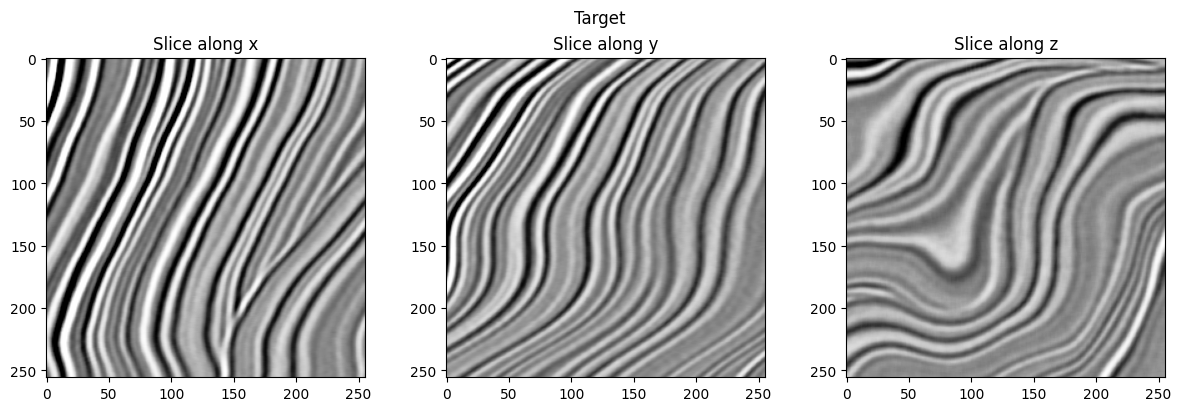

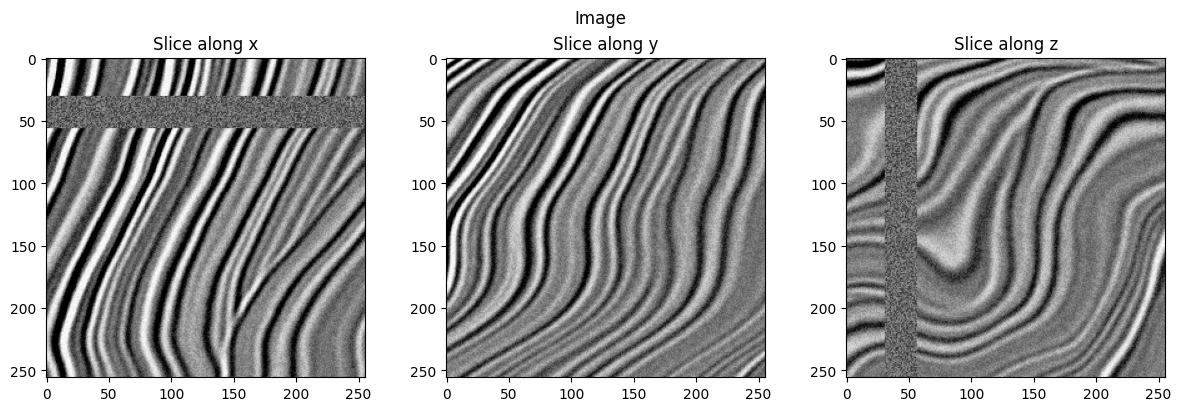

In [15]:
x, y, z = 50, 150, 200
for i, batch in enumerate(train_loader):
    target = nib.Nifti1Image(batch['target'].numpy()[0, 0], np.eye(4))
    image = nib.Nifti1Image(batch['image'].numpy()[0, 0], np.eye(4))
    plot_slice(target, x, y, z, f'Target')
    plot_slice(image, x, y, z, f'Image')
    
    print(f'Target stats: {np.mean(target.get_fdata()), np.min(target.get_fdata()), np.max(target.get_fdata())}')
    print(f'Image stats: {np.mean(image.get_fdata()), np.min(image.get_fdata()), np.max(image.get_fdata())}')

In [16]:
logger = TensorBoardLogger("tb_logs", name=model_name)

In [17]:
max_epochs = 200

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor=None, save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=True,
    logger=logger
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /teamspace/studios/this_studio/training/TEST-GAN exists and is not empty.

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 587 K  | train
1 | D    | Discriminator | 410 K  | train
-----------------------------------------------
997 K     Trainable params
0         Non-trainable params
997 K     Total params
3.988     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [21]:
gan = GAN3D.load_from_checkpoint(checkpoint_dir / 'epoch=199-val_loss=1.00-train_loss=0.00.ckpt', target_data_dir=TARGET_DATA_DIR, model_dir=checkpoint_dir, 
percentile=percentile, n_critic=n_critic, recon_loss=lambda x, y: 0)
gan.eval()

GAN3D(
  (G): Generator(
    (down1): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (down2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (inv_res_h_1): InvertedResidual3d(
      (conv): Sequential(
        (0): ConvBNReLU3d(
          (0): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): ConvBNReLU3d(
          (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=128, bias=F

In [22]:
gan.prepare_data()
train_loader = gan.train_dataloader()

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [1]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

for i, batch in enumerate(train_loader):
    prediction = gan(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

NameError: name 'train_loader' is not defined